In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("labelled_data.csv")  
df.head()

,title,label
0,"Gujarat business leaders, family members kille...",0
1,Retail inflation cools to a six-year low of 2....,1
2,India's CPI Inflation In May 2025 Falls To 2.8...,1
3,Nainital Back In Business: After Rs 60 Crore H...,1
4,extra buses clear tourist traffic,1


In [3]:
df.columns[0]

'title'

In [4]:
df.shape

(186, 2)

Cleaning Text

In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
stop_words= set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

In [8]:
def clean_text(text):
  text=text.lower()
  words=[]
  text=word_tokenize(text)
  for word in text:
    if(word.isalnum() and word not in stop_words):
      words.append(word)
  for word in words:
    lemmatizer.lemmatize(word)

  return " ".join(words)



In [9]:
a="Retailers shut shops as fuel prices rise sharply in Delhi	"
clean_text(a)

'retailers shut shops fuel prices rise sharply delhi'

In [10]:
df['title']=df['title'].apply(clean_text)

In [11]:
df.head()

,title,label
0,gujarat business leaders family members killed...,0
1,retail inflation cools low may moderating food...,1
2,india cpi inflation may 2025 falls lowest sinc...,1
3,nainital back business rs 60 crore hit tourism...,1
4,extra buses clear tourist traffic,1


now convert the text to numbers..

In [12]:
df.to_csv('labelled_data.csv',index=False)

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df['title'],df['label'],test_size=0.2)

In [14]:
x_train.shape

(148,)

In [15]:
y_train.shape

(148,)

In [16]:
df['label'].value_counts()


,count
label,
0,96
1,90


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [23]:
import numpy as np

In [39]:
# Load data
df_labeled = pd.read_csv("labelled_data.csv")  
df_unlabeled = pd.read_csv("filtered_data.csv")  # only 'headline_text' 

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))


X_labeled = vectorizer.fit_transform(df_labeled['title'])
y_labeled = df_labeled['label']

X_unlabeled = vectorizer.transform(df_unlabeled['headline_text'])

# Initialize model
model = LogisticRegression(max_iter=100)


# Start loop
for iteration in range(5):
    print(f"\n===== Iteration {iteration + 1} =====")

    # Train on current labeled data
    model.fit(X_labeled, y_labeled)

    # Predict on unlabeled data
    probs = model.predict_proba(X_unlabeled)
    preds = model.predict(X_unlabeled)

    # Get high-confidence predictions (label 1 or 0)
    max_probs = np.max(probs, axis=1)
    confident_indices = np.where(max_probs >= 0.92)[0]

    if len(confident_indices) == 0:
        print("No confident predictions found. Stopping early.")
        break

    # Add confident pseudo-labeled data to training set
    new_texts = df_unlabeled.iloc[confident_indices]['headline_text']
    new_labels = preds[confident_indices]

    # Append to labeled dataset
    df_new = pd.DataFrame({'title': new_texts, 'label': new_labels})
    df_labeled = pd.concat([df_labeled, df_new], ignore_index=True)

    df_labeled.to_csv('labelled_data.csv',index=False)

    # Remove used data from unlabeled set
    df_unlabeled = df_unlabeled.drop(df_unlabeled.index[confident_indices]).reset_index(drop=True)
    df_unlabeled.to_csv('filtered_data.csv',index=False)

    # Re-vectorize everything
    X_labeled = vectorizer.fit_transform(df_labeled['title'])
    y_labeled = df_labeled['label']
    X_unlabeled = vectorizer.transform(df_unlabeled['headline_text'])

    print(f"Added {len(confident_indices)} new pseudo-labeled samples. Total labeled: {len(df_labeled)}")
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefficients = model.coef_[0]
    top_pos = np.argsort(coefficients)[-10:][::-1]

    print("\nTop positive features (class 1):")
    for i in top_pos:
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")



===== Iteration 1 =====
No confident predictions found. Stopping early.



Final Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33038
           1       1.00      0.96      0.98      2089

    accuracy                           1.00     35127
   macro avg       1.00      0.98      0.99     35127
weighted avg       1.00      1.00      1.00     35127

Accuracy: 0.9976


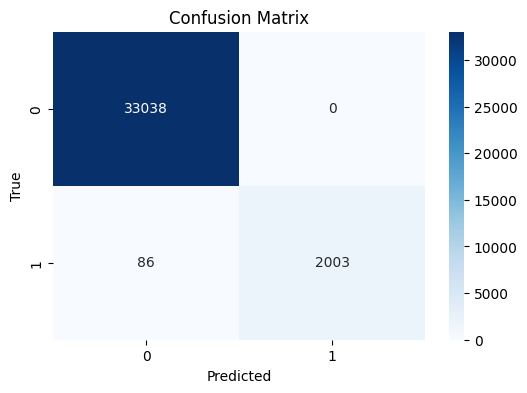

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_labeled)

# Classification report
print("\nFinal Evaluation:")
print(classification_report(y_labeled, y_pred))

# Accuracy
acc = accuracy_score(y_labeled, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_labeled, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [42]:
def predict_type(text):
    cleaned_text = clean_text(text)
    vector = vectorizer.transform([cleaned_text])

    label = model.predict(vector)[0]
    prob = model.predict_proba(vector)[0][1]  # Probability for label 1 (retailer-related)

    return label, prob


In [52]:
df_labeled.to_csv("final_labelled_data.csv")

In [51]:
predict_type("truckers strike maharashtra enters third day	")

(np.int64(1), np.float64(0.8866083150528581))

In [54]:
import pickle
pickle.dump(vectorizer,open('vectorizer.pkl','wb'))
pickle.dump(model,open('model.pkl','wb'))

doneeee

rest
---



In [ ]:
vectorizer=TfidfVectorizer(max_features=100)

In [ ]:
x_train_tfidf=vectorizer.fit_transform(x_train)
x_test_tfidf=vectorizer.fit_transform(x_test)
x_train_tfidf.shape

(148, 100)

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()

In [ ]:
model.fit(x_train_tfidf,y_train)

LogisticRegression()

In [ ]:
y_pred=model.predict(x_test_tfidf)

In [ ]:
import matplotlib.pyplot as plt

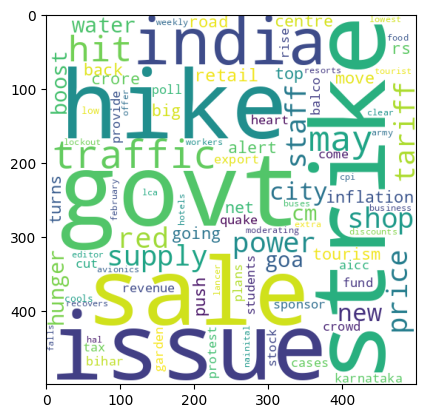

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
words= wc.generate(df[df['label']==1]['title'].str.cat(sep=" "))
plt.imshow(words)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

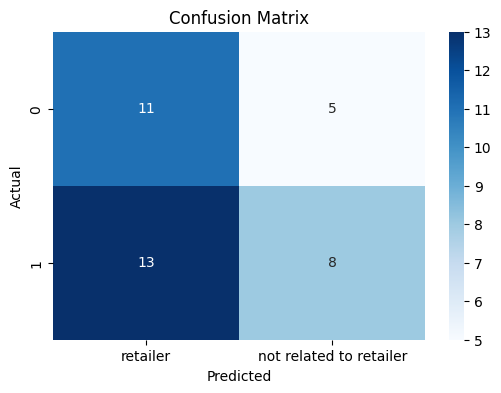

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True, fmt ='d', cmap ='Blues', xticklabels=['retailer','not related to retailer'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_type(text):
  text=clean_text(text)
  texttfidf=vectorizer.transform([text])
  y=model.predict(texttfidf)
  if( y[0] == 1):
    return 1
  else:
    return 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score


In [ ]:
accuracy= accuracy_score(y_test,y_pred)
print(accuracy)
recall = recall_score(y_test,y_pred)
print(recall)
prec = precision_score(y_test,y_pred)
print(prec)
f= f1_score(y_test,y_pred)
print(f)

0.5135135135135135
0.38095238095238093
0.6153846153846154
0.47058823529411764


In [ ]:
unlabelled_df=pd.read_csv("filtered_data.csv")

In [ ]:
unlabelled_df.head()

,headline_text,label
0,extra buses clear tourist traffic,1
1,move stop freedom fighters pension flayed,0
2,bjp jumps rail track conversion issue,0
3,state may take ap court krishna,0
4,weekly editor resorts hunger strike,1


In [ ]:
vectorizer=TfidfVectorizer(max_features=5000)

In [ ]:
x_label=vectorizer.fit_transform(df['title'])
y_label=df['label']

In [ ]:
model= LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(x_label,y_label)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
x_unlabel=vectorizer.transform(unlabelled_df['headline_text'])
predicted_label=model.predict(x_unlabel)
probab= model.predict_proba(x_unlabel)

In [ ]:
import numpy as np

In [ ]:
max_probs= np.max(probab,axis=1)
conf = max_probs >0.75
df_pseudo=unlabelled_df[conf].copy()
df_pseudo['label']=predicted_label[conf]


In [ ]:
df_pseudo.head()

,headline_text,label
2627,take net doctoral prog,0
6895,strike threatened fee hike,1
7279,net telephony yet take,0
9204,women pgs lawyers take police jobs,0
14971,govt staff strike damp squib city,1


In [ ]:
df_pseudo.shape

(8, 2)

In [ ]:
predict_type("Curfew imposed in parts of Maharashtra amid protests")

0

In [ ]:
predict_type("PM Modi inaugurates new expressway project	")

0

In [ ]:
predict_type("New fashion store opens in Bengaluru shopping mall	")

0

In [ ]:
predict_type("Nvips suffer power supply stopped govt guest houses	")

1

In [ ]:
retail_keywords = ["retail", "retailer", "kirana", "shop", "store", "vendor", "inventory", "supply", "shortage", "sale",
                   "discount", "customer", "revenue", "profit", "loss","shutdown", "e-commerce", "GST","staff", "strike","crowd","traffic","rises","alert"
                   "consumer","lockdown"]

In [ ]:
#gettng synoymns of these via WordNet
nltk.download('wordnet')
nltk.download('omw-1.4')  # For more multilingual synonyms

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): ##loop for all meanings of the word
        for lemma in syn.lemmas():  ##loop to all synonym of that word with similar meaning
            synonyms.add(lemma.name().lower().replace("_", " "))
    return list(synonyms)


In [ ]:
keywords=[]
for word in retail_keywords:
   keywords+=(get_synonyms(word))

In [ ]:
keywords

['retail',
 'retailer',
 'retail merchant',
 'shop',
 'betray',
 'patronize',
 'shop at',
 'buy at',
 'denounce',
 'give away',
 'patronise',
 'sponsor',
 'browse',
 'frequent',
 'shop class',
 'shit',
 'stag',
 'store',
 'workshop',
 'snitch',
 'tell on',
 'grass',
 'rat',
 'memory',
 'storage',
 'put in',
 'stash away',
 'shop',
 'computer storage',
 'memory board',
 'depot',
 'hive away',
 'stack away',
 'computer memory',
 'fund',
 'stock',
 'lay in',
 'entrepot',
 'salt away',
 'store',
 'storehouse',
 'seller',
 'marketer',
 'vendor',
 'vender',
 'trafficker',
 'armoury',
 'stock-taking',
 'stock-take',
 'take stock',
 'stocktaking',
 'stock',
 'inventorying',
 'armory',
 'stock list',
 'inventory',
 'render',
 'provide',
 'furnish',
 'ply',
 'add',
 'issue',
 'append',
 'provision',
 'supply',
 'supplying',
 'cater',
 'shortfall',
 'deficit',
 'shortage',
 'famine',
 'dearth',
 'sale',
 'sales agreement',
 'cut-rate sale',
 'sales event',
 'rebate',
 'brush off',
 'price reducti

In [ ]:
df=pd.read_csv("india-news-headlines.csv")

In [ ]:
df.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [ ]:
df.pop('publish_date')

,publish_date
0,20010102
1,20010102
2,20010102
3,20010102
4,20010102
...,...
3876552,20230630
3876553,20230630
3876554,20230630
3876555,20230630


In [ ]:
df.head()

,headline_category,headline_text
0,unknown,Status quo will not be disturbed at Ayodhya; s...
1,unknown,Fissures in Hurriyat over Pak visit
2,unknown,America's unwanted heading for India?
3,unknown,For bigwigs; it is destination Goa
4,unknown,Extra buses to clear tourist traffic


In [ ]:
df.head()

,headline_category,headline_text
0,unknown,Status quo will not be disturbed at Ayodhya; s...
1,unknown,Fissures in Hurriyat over Pak visit
2,unknown,America's unwanted heading for India?
3,unknown,For bigwigs; it is destination Goa
4,unknown,Extra buses to clear tourist traffic


In [ ]:
df['label']=0


In [ ]:
df

,headline_category,headline_text,label
0,unknown,Status quo will not be disturbed at Ayodhya; s...,0
1,unknown,Fissures in Hurriyat over Pak visit,0
2,unknown,America's unwanted heading for India?,0
3,unknown,For bigwigs; it is destination Goa,0
4,unknown,Extra buses to clear tourist traffic,0
...,...,...,...
3876552,city.goa,10 PIs move HC over thwarted seniority,0
3876553,city.goa,Govt notifies award in memory of Parrikar for ...,0
3876554,city.goa,After youth's death; PWD installs crash barrie...,0
3876555,city.goa,Authorities not acting against CRZ violations,0


In [ ]:
for data in range(df.shape[0]):
  print(df['headline_category'][data])
  break

unknown


In [ ]:
for data in range(df.shape[0]):
  print(df['headline_category'][data])
  print(df['headline_text'][data])
  print("label:",df['label'][data])
  q=int(input("enter: "))
  if q==1 or q==0:
    df['label'][data]=q
  else:
    break

unknown
Status quo will not be disturbed at Ayodhya; says Vajpayee
label: 0


KeyboardInterrupt: Interrupted by user

In [ ]:
df.head()

,headline_category,headline_text,label
0,unknown,Status quo will not be disturbed at Ayodhya; s...,0
1,unknown,Fissures in Hurriyat over Pak visit,0
2,unknown,America's unwanted heading for India?,0
3,unknown,For bigwigs; it is destination Goa,0
4,unknown,Extra buses to clear tourist traffic,1


In [ ]:
df.shape

(3876557, 3)

In [ ]:
df=df.drop_duplicates(subset=["headline_text"])

In [ ]:
df.shape

(3604755, 3)

In [ ]:
s=10

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
for data in range(s,df.shape[0]):
  print(df['headline_category'][data])
  print(df['headline_text'][data])
  print("label:",df['label'][data])
  q=input("enter: ")
  if q=='1' or q=='0':
    df.loc[data,'label']=int(q)
  else:
    s=data;
    break

unknown
Govt plans stadium near Panaji
label: 0
enter: 1
unknown
BJP doing a volte face on casinos: Cong
label: 0
enter: 1
unknown
3 watershed projects on the anvil
label: 0
enter: 1
unknown
No report yet on fire in Udyog Bhavan
label: 0
enter: 1
unknown
He is the king of 'five star' industry
label: 0
enter: 1
unknown
Petrol pump sealed for selling adulterated fuel
label: 0
enter: 1
unknown
Milk price up by Rs 1 per litre
label: 0
enter: 1
unknown
Congress House is no-smoking zone
label: 0
enter: 0
unknown
Rural weightage: Govt reassures Governor
label: 0
enter: 0
unknown
Bride gets honeymoon surprise: Chopper ride
label: 0
enter: 0
unknown
Is hangover a sign of alcoholicism?
label: 0
enter: 0
unknown
Almatti: AP to wait and watch
label: 0
enter: 0
unknown
10-year-old girl missing
label: 0
enter: 0
unknown
Hear his messages from the heart
label: 0
enter: 0
unknown
Dance like no one's watching
label: 0
enter: 0
unknown
From reel love to real love
label: 0
enter: 0
unknown
Power row: Bri

In [ ]:
s

136

In [ ]:
t_df=df.head(500000)

In [ ]:
t_df['headline_text']=t_df['headline_text'].apply(clean_text)

<ipython-input-159-1344700113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['headline_text']=t_df['headline_text'].apply(clean_text)


In [ ]:
t_df.head()

,headline_category,headline_text,label
0,unknown,status quo disturbed ayodhya says vajpayee,0
1,unknown,fissures hurriyat pak visit,0
2,unknown,america unwanted heading india,0
3,unknown,bigwigs destination goa,0
4,unknown,extra buses clear tourist traffic,0


In [ ]:
new_df=t_df[t_df['headline_text'].apply(lambda x: any(k in x.split() for k in keywords))].copy()
new_df.head()

,headline_category,headline_text,label
4,unknown,extra buses clear tourist traffic,0
8,unknown,move stop freedom fighters pension flayed,0
19,unknown,bjp jumps rail track conversion issue,0
20,unknown,state may take ap court krishna,0
50,unknown,weekly editor resorts hunger strike,0


In [ ]:
new_df = new_df.reset_index(drop=True)
new_df.head()

,headline_category,headline_text,label
0,unknown,extra buses clear tourist traffic,0
1,unknown,move stop freedom fighters pension flayed,0
2,unknown,bjp jumps rail track conversion issue,0
3,unknown,state may take ap court krishna,0
4,unknown,weekly editor resorts hunger strike,0


In [ ]:
new_df.shape

(35413, 3)

In [ ]:
new_df.to_csv("filtered_data.csv", index=False)

In [ ]:
new_df.head()

,headline_category,headline_text,label
0,unknown,extra buses clear tourist traffic,1
1,unknown,move stop freedom fighters pension flayed,1
2,unknown,bjp jumps rail track conversion issue,1
3,unknown,state may take ap court krishna,1
4,unknown,weekly editor resorts hunger strike,1


In [ ]:
s=0

In [ ]:
s+=10

In [ ]:
for data in range(s,new_df.shape[0]):
  print(new_df['headline_category'][data])
  print(new_df['headline_text'][data])
  print("label:",new_df['label'][data])
  new_df.loc[data,'label']=predict_type(new_df['headline_text'][data])
  # print("new: label:",new_df['label'][data])
  # q=input("continue: ")
  # if q=='1':
  #   continue
  # elif q=='0':
  #   new_df.loc[data,'label']=1-new_df['label'][data]
  # else:
  #   s=data;
  #   break

Streaming output truncated to the last 5000 lines.
iim grads become crorepatis offers rise
label: 1
india
cpm warns upa take next step
label: 1
india
bjp stand firm power transfer issue
label: 1
india
sc ca dismiss govt
label: 1
india
cong steers clear issue
label: 1
city.nagpur
swindler cb net
label: 1
india
bjp take final decision karnataka today
label: 1
business.india-business
india inc losing working days due staff sickness study
label: 1
world.us
sonia gandhi raises disarmament issue un meet
label: 1
unknown
power transfer issue bjp ministers karnataka resign
label: 1
city.chandigarh
wife sale save husband punjab
label: 1
business.india-business
loan defaults rise
label: 1
india
pulse prices may rise supply myanmar hit
label: 1
city.kolkata
gang looting spree salt lake
label: 1
city.nagpur
8 city hotels face closure
label: 1
city.nagpur
gmc doctors call strike
label: 1
city.pune
shop workers held captive owners
label: 1
city.delhi
blueline staff push woman bus
label: 1
sports.icc

In [ ]:
s

80

In [ ]:
new_df.head(80)

,headline_category,headline_text,label
0,unknown,extra buses clear tourist traffic,1
1,unknown,move stop freedom fighters pension flayed,0
2,unknown,bjp jumps rail track conversion issue,1
3,unknown,state may take ap court krishna,0
4,unknown,weekly editor resorts hunger strike,1
...,...,...,...
75,unknown,stf another brush veerappan gang,0
76,unknown,dearth chemist shops city,1
77,unknown,skipping around sponsor,1
78,unknown,pact device ease network traffic,1


In [ ]:
new_df['label'].value_counts()


,count
label,
1,33419
0,1994


In [ ]:
X_all = vectorizer.transform(df['headline_text'])
model.predict_proba(X_all)[:, 1]  # probability for label 1


array([0.98256062, 0.98568857, 0.98734009, ..., 0.9880777 , 0.98795841,
       0.98308832])

In [ ]:
new_df.head()

,headline_category,headline_text,label
0,unknown,extra buses clear tourist traffic,1
1,unknown,move stop freedom fighters pension flayed,0
2,unknown,bjp jumps rail track conversion issue,1
3,unknown,state may take ap court krishna,0
4,unknown,weekly editor resorts hunger strike,1


In [ ]:
new_df.pop('headline_category')

,headline_category
0,unknown
1,unknown
2,unknown
3,unknown
4,unknown
...,...
35408,city.delhi
35409,sports.icc-world-cup-2015
35410,world.us
35411,entertainment.hindi.bollywood


In [ ]:
new_df.to_csv("filtered_data.csv",index=False)